## Defining a custom gym environment
- Note this example was modified from the [gymnasium documentation](https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/)
- Observations provide the cost surface, location of the agent and location of the target.
- There are 4 actions in our environment, corresponding to the movements "right", "up", "left", and "down".
- A done signal is issued as soon as the agent has navigated to the grid cell where the target is located.
<!-- - Rewards are binary and sparse, meaning that the immediate reward is always zero, unless the agent has reached the target, then it is 1. -->

In [2]:
import grid_world as _
import gymnasium as gym

import numpy as np

import random
from collections import deque, namedtuple

import imageio
import matplotlib.pyplot as plt
from IPython import display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from gymnasium.wrappers import FlattenObservation

In [3]:
# Check if cuda/GPU available
torch.cuda.is_available()

True

In [4]:
# Import the custom gym environment
env = gym.make('grid_world/GridWorld-v2')
observation, info = env.reset()
env.close()

{'target': array([3, 2]), 'agent': array([0, 3])}


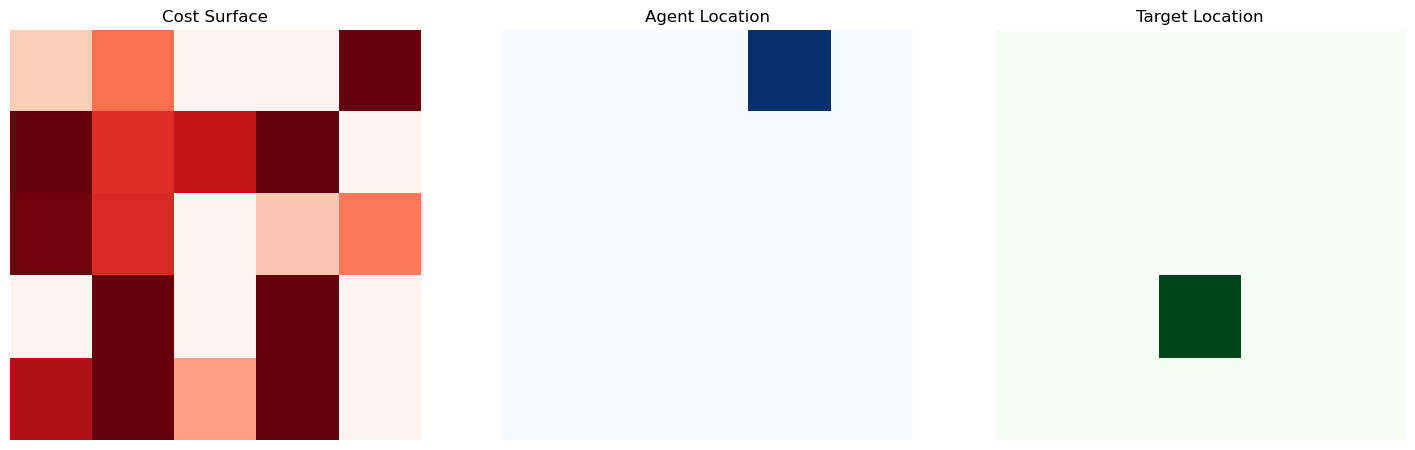

In [5]:
shape = (5,5)
env = gym.make('grid_world/GridWorld-v2', render_mode=None, shape=shape)
observation, info = env.reset(grid_seed=2, start_target_seed=42)
print(info)
grid = observation[:shape[0]*shape[1]].reshape(shape)
agent = observation[shape[0]*shape[1]:shape[0]*shape[1]*2].reshape(shape)
target = observation[shape[0]*shape[1]*2:shape[0]*shape[1]*3].reshape(shape)
# grid, agent, target = observation['grid'], observation
env.close()
fig,ax = plt.subplots(ncols=3, figsize=(18,6))
ax[0].margins(0.01)
ax[0].axis('off')
ax[0].set_title('Cost Surface')
ax[0].imshow(grid, cmap='Reds')

ax[1].margins(0.01)
ax[1].axis('off')
ax[1].set_title('Agent Location')
ax[1].imshow(agent, cmap='Blues')

ax[2].margins(0.01)
ax[2].axis('off')
ax[2].set_title('Target Location')
ax[2].imshow(target, cmap='Greens')

plt.show()

## Rendering in human mode

In [6]:
## Test the environment
env = gym.make('grid_world/GridWorld-v1', render_mode='human', shape=shape)
observation, info = env.reset()
t = 0
rng = np.random.default_rng()


for i in range(10):
      
   action = env.action_space.sample()
   observation, reward, terminated, truncated, info = env.step(action)
   print(info)


   if terminated or truncated:
      observation, info = env.reset(seed=10)
      t += 1

env.close()

/home/ben/miniconda3/envs/maps/lib/python3.9/site-packages/gymnasium/envs/registration.py:523: DeprecationWarning: WARN: The environment grid_world/GridWorld-v1 is out of date. You should consider upgrading to version `v2`.
  logger.deprecation(


{'target': array([0, 2]), 'agent': array([2, 2])}
{'target': array([0, 2]), 'agent': array([2, 3])}
{'target': array([0, 2]), 'agent': array([3, 3])}
{'target': array([0, 2]), 'agent': array([4, 3])}
{'target': array([0, 2]), 'agent': array([3, 3])}
{'target': array([0, 2]), 'agent': array([3, 4])}
{'target': array([0, 2]), 'agent': array([2, 4])}
{'target': array([0, 2]), 'agent': array([1, 4])}
{'target': array([0, 2]), 'agent': array([0, 4])}
{'target': array([0, 2]), 'agent': array([0, 4])}


## Rendering in RGB Array Mode (gif)

In [7]:
# INSTANTIATE THE ENVIRONMENT
env = gym.make('grid_world/GridWorld-v1', render_mode='rgb_array', shape=shape)


random_images = []
observation, info = env.reset()

# SAVE IMAGE OF THE INITIAL STATE
random_images.append(env.render())

# ITERATE OVER SET NUMBER OF TRANSITIONS
for i in range(100):

    if i%2 == 0:
        action = 0
    else:
      action = 1

    # TAKE A RANDOM ACTION AND OBSERVE THE RESULT
    observation, reward, terminated, truncated, info = env.step(action)
    random_images.append(env.render())

    if terminated or truncated:
        observation, info = env.reset()

env.close()
imageio.mimsave('./gifs/random-net.gif', random_images, fps = 5)  

In [8]:
class DQN(nn.Module):

    def __init__(self, n_observations, hidden, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, hidden)
        self.layer2 = nn.Linear(hidden, hidden)
        self.layer3 = nn.Linear(hidden, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [9]:
Transition = namedtuple(
    'Transition',
    ('state', 'action', 'next_state', 'reward', 'done')
    )


class ReplayMemory(object):
    """
    A class to store gym transitions
    """
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [10]:
# def concat_observation(state_dictionary):
#     arrays = [arr for arr in state_dictionary.values()]
#     return np.concatenate(arrays, axis=0)

In [11]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the AdamW optimizer
# HIDDEN is the number of units in the first and second layer
# MEMORY is the length of the replay memory
# NUM_EPISODES the number of training episodes
BATCH_SIZE = 128
GAMMA = 0.9
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 10000
TAU = 0.005
LR = 1e-4
HIDDEN = 256
MEMORY = 1000
NUM_EPISODES = 500
SHAPE = (10,10)

# Define device used for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

env = gym.make('grid_world/GridWorld-v2', shape=SHAPE)

# Get the number of actions available
n_actions = env.action_space.n
print('Number of Actions:', n_actions)

# RESET THE ENVIRONMENT
observation, info = env.reset()

# GET THE NUMBER OF FEATURES IN A STATE
n_observations = observation.shape[0]
print('Observation Size', n_observations)

# DEFINE THE POLICY AND TARGET NET AS INSTANCES OF THE DQN MODEL
policy_net = DQN(n_observations, HIDDEN, n_actions).to(device)
target_net = DQN(n_observations, HIDDEN, n_actions).to(device)

# SYNC THE WEIGHTS OF THE TARGET AND POLICY NETS
target_net.load_state_dict(policy_net.state_dict())

# DEFINE THE OPTIMIZER
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

# DEFINE THE REPLAY MEMORY 
memory = ReplayMemory(MEMORY)

steps_done = 0

Device: cuda
Number of Actions: 4
Observation Size 300


In [12]:
def eps_decay(steps_done):
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * steps_done / EPS_DECAY)
    return eps_threshold

In [13]:
def select_action(state, eps):

    threshold = random.random()

    if threshold > eps:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


# TEST YOUR FUNCTION
observation, info = env.reset()
state_tensor = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
print('The observation:\n')
print(state_tensor, '\n')
print('The policy net predictions:\n')
with torch.no_grad():
    print(policy_net(state_tensor), '\n')
    print(policy_net(state_tensor).max(1)[1].view(1, 1), '\n')
print('Using the select action function:', '\n')
action = select_action(state_tensor, eps=0)
print(action)

The observation:

tensor([[0.0000, 0.0429, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.3970, 1.0000, 0.7145, 0.0000, 0.9037, 0.0000, 1.0000, 0.0000, 0.6100,
         0.0000, 0.0170, 0.0000, 0.0717, 1.0000, 0.9414, 0.0746, 1.0000, 0.0000,
         1.0000, 0.0000, 0.8312, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000,
         0.5875, 0.2382, 0.0000, 1.0000, 0.8242, 0.3900, 0.6739, 0.0000, 0.7209,
         0.3838, 0.0000, 0.2463, 0.7955, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000,
         0.1552, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000,
         0.4514, 0.2182, 1.0000, 0.0000, 1.0000, 0.2692, 0.0883, 0.0000, 0.0000,
         0.0000, 1.0000, 1.0000, 1.0000, 0.1800, 0.9046, 0.0000, 0.7277, 0.0000,
         1.0000, 0.0000, 1.0000, 0.0000, 0.8517, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.8187, 0.0000, 0.1880, 0.0000, 1.0000, 0.0000, 0.6711, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0

In [14]:
def optimize_model():

    # CHECK THE LENGTH OF THE REPLAY MEMORY, RETURN NONE IF LENGTH LESS THAN
    # THE BATCH_SIZE
    if len(memory) < BATCH_SIZE:
        return
    
    # SAMPLE A TRANSITION FROM THE REPLAY MEMORY
    transitions = memory.sample(BATCH_SIZE)

    # DEFINE THE BATCH AS TRANSITION NAMED TUPLE, THIS SPLITS state's, 
    # action's, next_state's, and reward's into tuples see the following link
    # https://stackoverflow.com/a/19343/3343043
    batch = Transition(*zip(*transitions))

    # FIND THE INDICES OF TRANSITIONS THAT ARE NON-TERMINAL STATES
    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)), 
        device=device, 
        dtype=torch.bool
        )
    
    # FIND THAT STATES THAT ARE NON-TERMINAL STATES
    non_final_next_states = torch.cat(
        [s for s in batch.next_state if s is not None]
        )
    

    ### CREATE 3 TENSORS ONE FOR THE STATES, ACTIONS AND REWARDS
    # COMBINE THE STATE SAMPLES INTO SINGLE TENSOR WITH torch.cat()
    state_batch = torch.cat(batch.state)
    # COMBINE THE ACTION SAMPLES INTO SINGLE TENSOR WITH torch.cat()
    action_batch = torch.cat(batch.action)
    # COMBINE THE REWARD SAMPLES INTO SINGLE TENSOR WITH torch.cat()
    reward_batch = torch.cat(batch.reward)

    # GET THE ACTION VALUES OF POLICY NET FOR EACH ACTION WHICH WAS TAKEN
    # HERE YOU SHOULD USE tensor.gather() METHOD SO YOU CAN SPECIFY WHICH 
    # ACTION WE ARE INTERESTED IN. WE ONLY WANT THE ACTION WHICH WAS TAKEN
    # FOR THE TRANSACTION
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # CREATE TENSOR OF ZEROS TO STORE THE NEXT STATE VALUES
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    
    # DO NOT CALCULATE GRADIENTS
    with torch.no_grad():

        # DEFINE THE NEXT STATE Q VALUES USING THE TARGET NET - max(Q_target(s', a'))
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
        
    # COMPUTE EXPECTED RETURN Y = Discount*max(Q_target(s',a)) + Reward 
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # DEFINE THE HUBER LOSS
    criterion = nn.SmoothL1Loss()

    # CALCULATE THE LOSS L(Q_policy(s,a), Y)
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # ZERO THE GRADIENTS
    optimizer.zero_grad()

    # PROPAGATE GRADIENT THROUGH NETWORK 
    loss.backward()

    # IN PLACE GRADIENT CLIPPING
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)

    # TAKE AN OPTIMIZER STEP W = W - LR*GRADIENT
    optimizer.step()

    return loss


In [15]:
a = np.array([[1,2,3], [4,5,6], [7,8,9]])
b = np.array([[1], [0], [1]])
a*b

array([[1, 2, 3],
       [0, 0, 0],
       [7, 8, 9]])

In [16]:
def plot_training(rewards, loss, eps, avg_rewards=None, nfns_ratio=None, done=False):
    fig = plt.figure(1, figsize=(18, 12))

    if done:
        plt.clf()

    else:
        plt.clf()

    # plt.subplots(ncols=2, figsize=(12,6))
    ax1 = fig.add_subplot(2, 3, 1)
    ax2 = fig.add_subplot(2, 3, 2)
    ax3 = fig.add_subplot(2, 3, 3)
    ax4 = fig.add_subplot(2, 3, 4)

    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Reward')
    ax1.plot(rewards)

    if avg_rewards:
        ax1.plot(avg_rewards)

    ax2.set_xlabel('Batch')
    ax2.set_ylabel('Loss')
    ax2.plot(loss)
    
    ax3.set_xlabel('Action')
    ax3.set_ylabel('Epsilon')
    ax3.plot(eps)
    
    ax4.set_xlabel('Batch')
    ax4.set_ylabel("Non-Final S' Ratio")
    ax4.plot(nfns_ratio)

    # plt.pause(0.001)
    
    if not done:
        display.display(plt.gcf())
        display.clear_output(wait=True)
    
    else:
        display.display(plt.gcf())

In [17]:
episode_rewards = []
avg_rewards = []
max_reward = 0
max_avg_reward = 0

optim_steps = 0
eps_values = []
max_reward = 0
max_avg_reward = 0
nfns_ratio = []

training_loss = []

total_transitions = 0

Complete


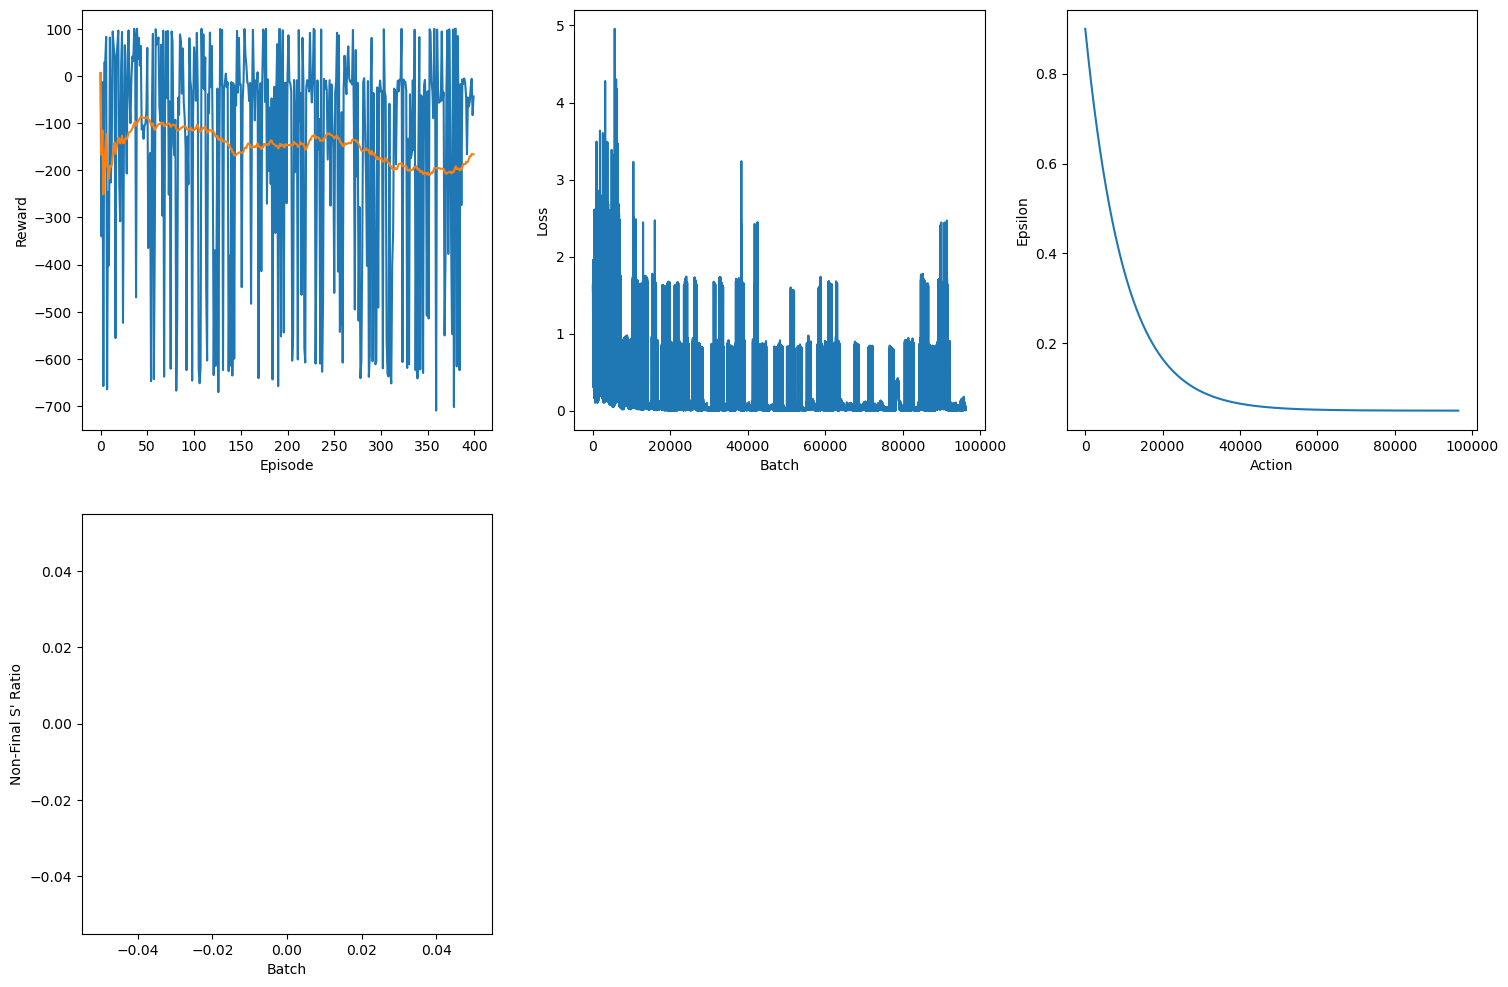

In [23]:
# start = time()
env = gym.make('grid_world/GridWorld-v2', shape=SHAPE)
# env = gym.make("LunarLander-v2")
lr = LR
NUM_EPISODES = 200
total_truncated = 0
grid_seed = 42
start_target_seed = None

for e in range(NUM_EPISODES):
    observation, info = env.reset(grid_seed=grid_seed, start_target_seed=start_target_seed)
    state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
    
    done = 0
    episode_reward = 0
    
    while not done:
        total_transitions += 1
        eps = eps_decay(total_transitions)
        # action, eps = selector.select(state.reshape(1,-1))
        eps_values.append(eps)

        action = select_action(state, eps)

        observation, reward, terminated, truncated, _ = env.step(action.item())
        episode_reward += reward
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        if truncated:
            total_truncated += 1

        if terminated:
            next_state = None
        
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        memory.push(state, action, next_state, reward, done)
        state = next_state

        # batch_loss, non_final_next_state_ratio = optimize_model([q_optimizer, t_optimizer], method='vanilla')
        # nfns_ratio.append(non_final_next_state_ratio)

        loss = optimize_model()

        if loss is not None:
            training_loss.append(loss.item())


        # Get the network weights
        # q_weights = [node.value.copy() for node in q_network.parameters()]
        # t_weights = [node.value.copy() for node in t_network.parameters()]

        # GET THE CURRENT WEIGHTS OF EACH NETWORK
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()

        # CALCULATE SOFT UPDATE OF TARGET NET WEIGHTS
        # θ′ ← τ θ + (1 −τ )θ′
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)

        # APPLY THE UPDATE TO THE TARGET NETWORK
        target_net.load_state_dict(target_net_state_dict)
    
        # if batch_loss is not None:
        #     optim_steps += 1
        #     batch_losses.append(batch_loss)
            
        #     # Get the network weights
        #     q_weights = [node.value.copy() for node in q_network.parameters()]
        #     t_weights = [node.value.copy() for node in t_network.parameters()]

        #     # Soft update of the target network's weights
        #     # θ′ ← τ θ + (1 − τ)θ′
        #     for i in range(len(q_weights)):
        #         t_weights[i] = q_weights[i]*TAU + t_weights[i]*(1-TAU)

        #     t_network.load_parameters(t_weights)

        # if optim_steps%10000 == 0:
        #     # Get the network weights
        #     q_weights = [node.value.copy() for node in q_network.parameters()]
        #     t_network.load_parameters(q_weights)


        if done:
            episode_rewards.append(episode_reward)
            avg_rewards.append(np.average(episode_rewards[-100:]))

            # if episode_reward > max_reward:
            #     max_reward = episode_reward
            #     for i, w in enumerate(q_weights):
            #         layer = 'layer{}'.format(i)
            #         np.save('./weights/{}.npy'.format(layer), w)

            plot_training(episode_rewards, training_loss, eps_values, avg_rewards, nfns_ratio)

print('Complete')
# end = time()
# plot_training(episode_rewards, show_result=True)
plt.ioff()
plt.show()

In [22]:
from time import sleep


env = gym.make('grid_world/GridWorld-v1', render_mode='human', shape=SHAPE)

# Initial observation and state
observation, info = env.reset(grid_seed=grid_seed, start_target_seed=start_target_seed)
state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
test_episode_rewards = []
G = 0
print(info)
# sleep(3)

for i in range(20):

    action = policy_net(state).max(1)[1].item() # Learned policy
    observation, reward, terminated, truncated, info = env.step(action)
    state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
    # print(info)
    G += reward
    # sleep(3)

    if terminated or truncated:
        observation, info = env.reset(grid_seed=grid_seed, start_target_seed=start_target_seed)
        test_episode_rewards.append(G)
        G = 0
        # print(info)
        # sleep(3)

    else:
        G += reward

env.close()
print(test_episode_rewards)

{'target': array([2, 3]), 'agent': array([1, 8])}
[]


In [19]:
## Test the environment
env = gym.make('grid_world/GridWorld-v1', render_mode='rgb_array', shape=SHAPE)
test_episode_rewards = []
G = 0
images = []

observation, info = env.reset(grid_seed=grid_seed, start_target_seed=start_target_seed)
images.append(env.render())

for _ in range(100):
    action = policy_net(state).max(1)[1].item() # Learned policy
    observation, reward, terminated, truncated, info = env.step(action)
    state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
    images.append(env.render())
    G += reward

    if terminated or truncated:
        observation, info = env.reset(grid_seed=grid_seed, start_target_seed=start_target_seed)
        test_episode_rewards.append(G)
        G = 0


env.close()
print(test_episode_rewards)
imageio.mimsave('./gifs/10-10-random_start-static_grid.gif', images, fps = 5)      

[]
